# **Stroke Prediction - 96% Accuracy**

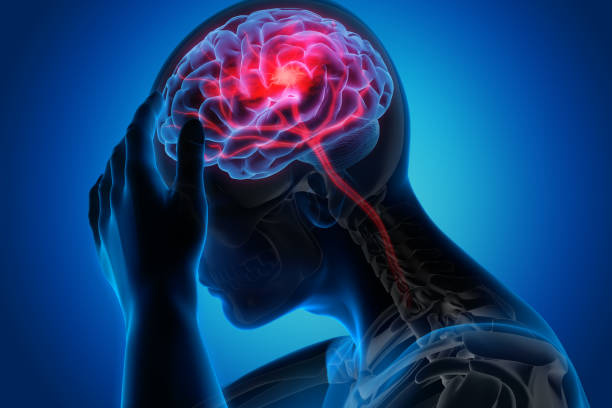

## **Context**

---


According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

## **Attribute Information**

---


1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [ ]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# function to set random colors to plot bars
def randomColorsToBars(color_start, increment_value, plot):
    cmap = plt.get_cmap('Paired')
    for patch in plot.patches:
        color = cmap(color_start)
        patch.set_color(color)
        color_start += increment_value

# init legends colors
cmap = plt.get_cmap('jet')
blue = cmap(0.25)
orange = cmap(0.8)
handles = [Rectangle((0,0), 1, 1, color=c, ec="k") for c in [blue, orange]]

In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
categorical = ['gender','hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']
numerical = ['avg_glucose_level', 'bmi','age']

df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### **Dataset generic info**

In [ ]:
df.describe(include="all")

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5109.000000,5109,5109.000000,5109.000000,5109.000000,5109,5109,5109,5109.000000,5109.000000,5109,5109.000000
unique,NaN,2,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2924,2596,NaN,NaN,1892,NaN
mean,36513.985516,NaN,43.229986,0.097475,0.054022,NaN,NaN,NaN,106.140399,28.946800,NaN,0.048738
std,21162.008804,NaN,22.613575,0.296633,0.226084,NaN,NaN,NaN,45.285004,7.726906,NaN,0.215340
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17740.000000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.240000,23.600000,NaN,0.000000
50%,36922.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.880000,28.300000,NaN,0.000000
75%,54643.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,32.800000,NaN,0.000000


## **Check for null values**

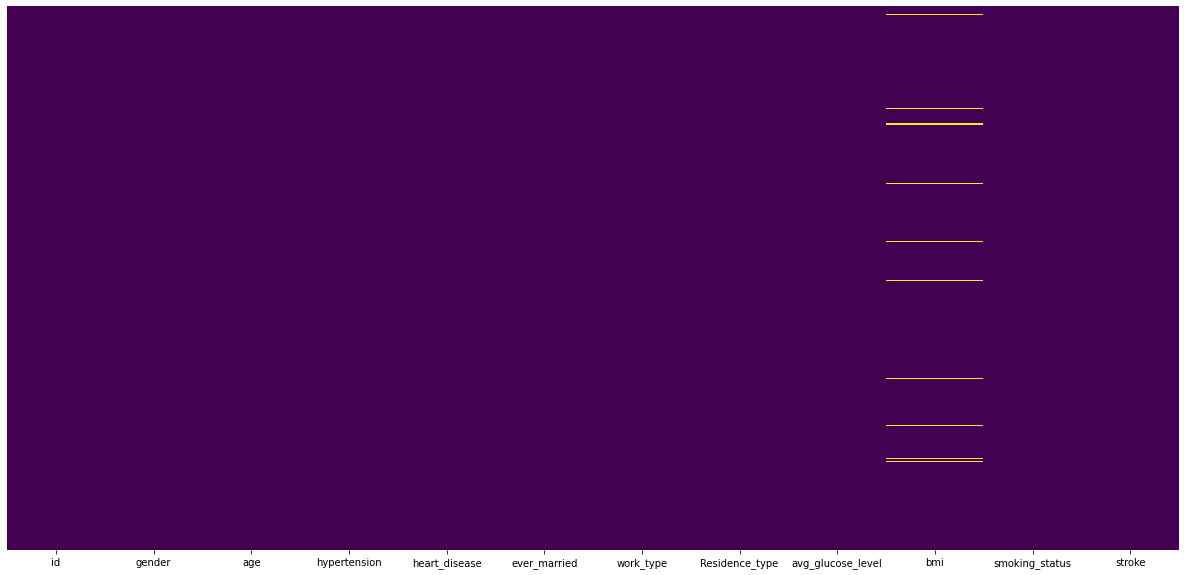

In [ ]:
plt.figure(figsize = (21,10))

# this heatmap show us where are the null values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [ ]:
print('Bmi null values:', df['bmi'].isna().sum(), sep=' ')

Bmi null values: 201


## **Replace null values**

* Divide the ages in four groups, get the bmi mean of each group and fill null
values of each group with the corresponding bmi mean

In [ ]:
max_age = df["age"].max()
group_size = round(max_age/4)
group_size

20

* First group age [0:20] get bmi mean

In [ ]:
# the rows with age between 0 and 20 will be set to true
age1 = df.groupby(df['age'].between(0, group_size, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean1 = round(age1[age1["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean1

22.2

* Second group age [21:40] get bmi mean

In [ ]:
# the rows with age between 21 and 40 will be set to true
age2 = df.groupby(df['age'].between(group_size+1, group_size*2, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean2 = round(age2[age2["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean2

30.0

* Third group age [41:60] get bmi mean

In [ ]:
# the rows with age between 41 and 60 will be set to true
age3 = df.groupby(df['age'].between(group_size*2+1, group_size*3, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean3 = round(age3[age3["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean3

31.7

* Fourth group age [61:82] get bmi mean

In [ ]:
# the rows with age between 61 and 82 will be set to true
age4 = df.groupby(df['age'].between(group_size*3+1, max_age, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean4 = round(age3[age4["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean4

31.7

Create new rows

In [ ]:
# get rows with age between specific range where bmi is null and fill it with bmi mean corresponding to the age range
new_rows1 = df[((df["age"]>=0) & (df["age"]<=group_size) & (df["bmi"].isna()))].fillna(bmi_mean1)
new_rows2 = df[((df["age"]>=group_size+1) & (df["age"]<=group_size*2) & (df["bmi"].isna()))].fillna(bmi_mean2)
new_rows3 = df[((df["age"]>=group_size*2+1) & (df["age"]<=group_size*3) & (df["bmi"].isna()))].fillna(bmi_mean3)
new_rows4 = df[((df["age"]>=group_size*3+1) & (df["age"]<=max_age) & (df["bmi"].isna()))].fillna(bmi_mean4)

new_rows = new_rows1.append(new_rows2.append(new_rows3.append(new_rows4)))
new_rows

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,22.2,Unknown,1
742,33723,Female,9.00,0,0,No,children,Urban,95.81,22.2,Unknown,0
872,2549,Female,17.00,0,0,No,Private,Rural,83.23,22.2,never smoked,0
1115,809,Male,13.00,0,0,No,children,Urban,71.73,22.2,Unknown,0
1194,542,Female,3.00,0,0,No,children,Urban,79.63,22.2,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4684,49894,Female,78.00,1,1,Yes,Private,Rural,206.53,31.7,never smoked,0
4713,2044,Female,70.00,0,1,Yes,Self-employed,Rural,65.68,31.7,Unknown,0
4750,16902,Female,70.00,0,1,Yes,Self-employed,Urban,240.69,31.7,smokes,0
4921,4062,Male,72.00,0,1,Yes,Private,Rural,238.27,31.7,smokes,0


Update with new rows removing null values

In [ ]:
# update old rows with new rows by index
for index in new_rows.index:
    df.iloc[index] = new_rows.loc[index]

print('Bmi null values:', df['bmi'].isna().sum(), sep=' ')

Bmi null values: 0


### **Gender and stroke**

> **Risultato**: i maschi sono più predisposti ad avere un ictus

Dal momento che gli 'Other' sono irrilevanti, eliminiamo le righe che contengono il genere 'Other'

In [ ]:
df.groupby('gender')["gender"].count()

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [ ]:
df = df.drop(df[df['gender'] == 'Other'].index)
df.groupby('gender')["gender"].count()

gender
Female    2994
Male      2115
Name: gender, dtype: int64

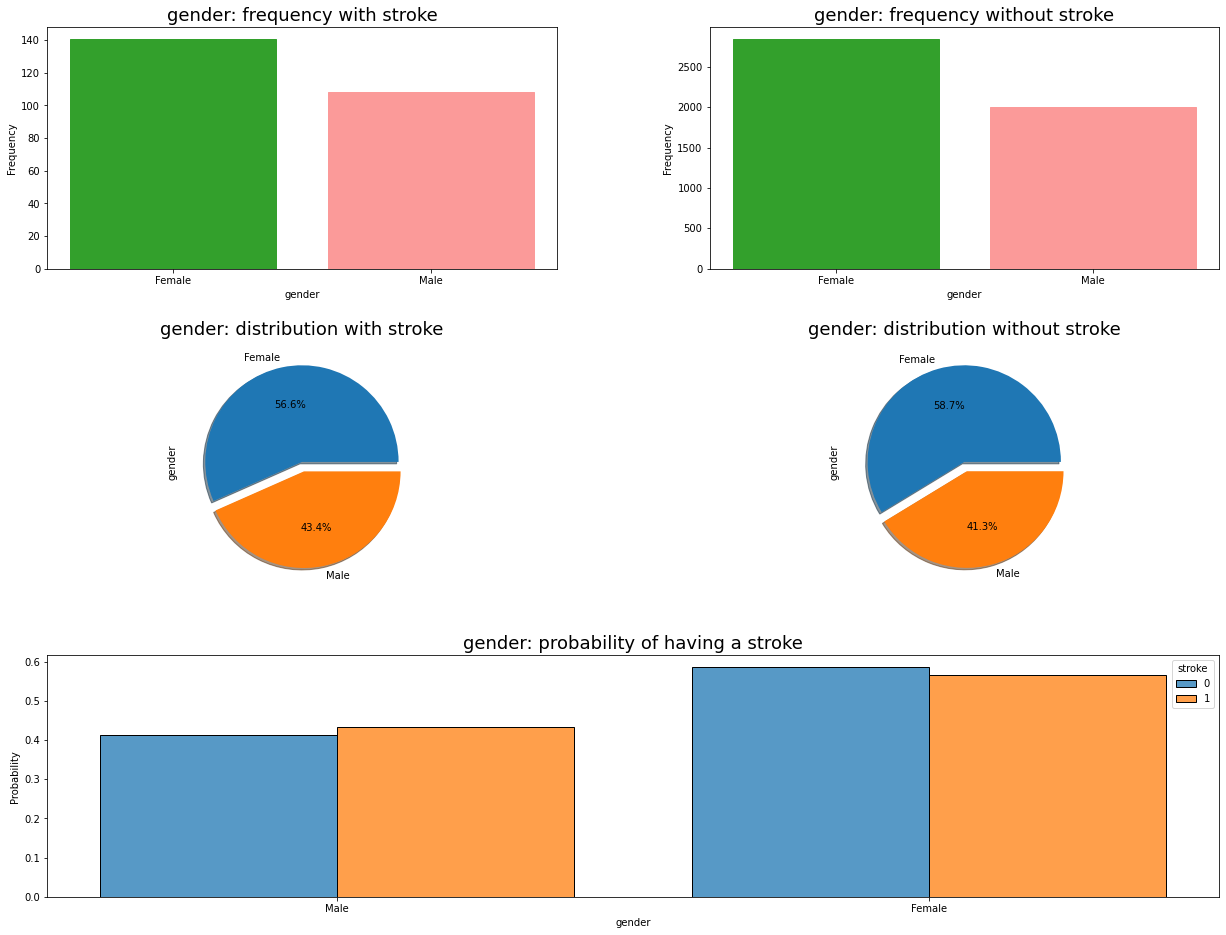

In [ ]:
gendersWithStroke = df[df["stroke"]==1].groupby("gender")["gender"].count().reset_index(name='counts')
gendersWithoutStroke = df[df["stroke"]==0].groupby("gender")["gender"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3)  # grid with 3 rows and 2 columns

# plot gender frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(gendersWithStroke["gender"].values, gendersWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("gender")
plt.title("gender: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot gender frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(gendersWithoutStroke["gender"].values, gendersWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("gender")
plt.title("gender: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot gender distribution with stroke
plt.subplot(grid[1, 0])
plt.title("gender: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('gender')['gender'].count().plot(kind='pie', y='gender', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot gender distribution without stroke
plt.subplot(grid[1, 1])
plt.title("gender: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('gender')['gender'].count().plot(kind='pie', y='gender', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot gender probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="gender", hue="stroke", stat="probability", common_norm=False, multiple="dodge", shrink=0.8)
plt.title('gender: probability of having a stroke', size=18)

plt.show()

### **Hypertension and stroke**

> **Risultato**: chi è affetto da ipertensione è più predisposto ad avere un ictus



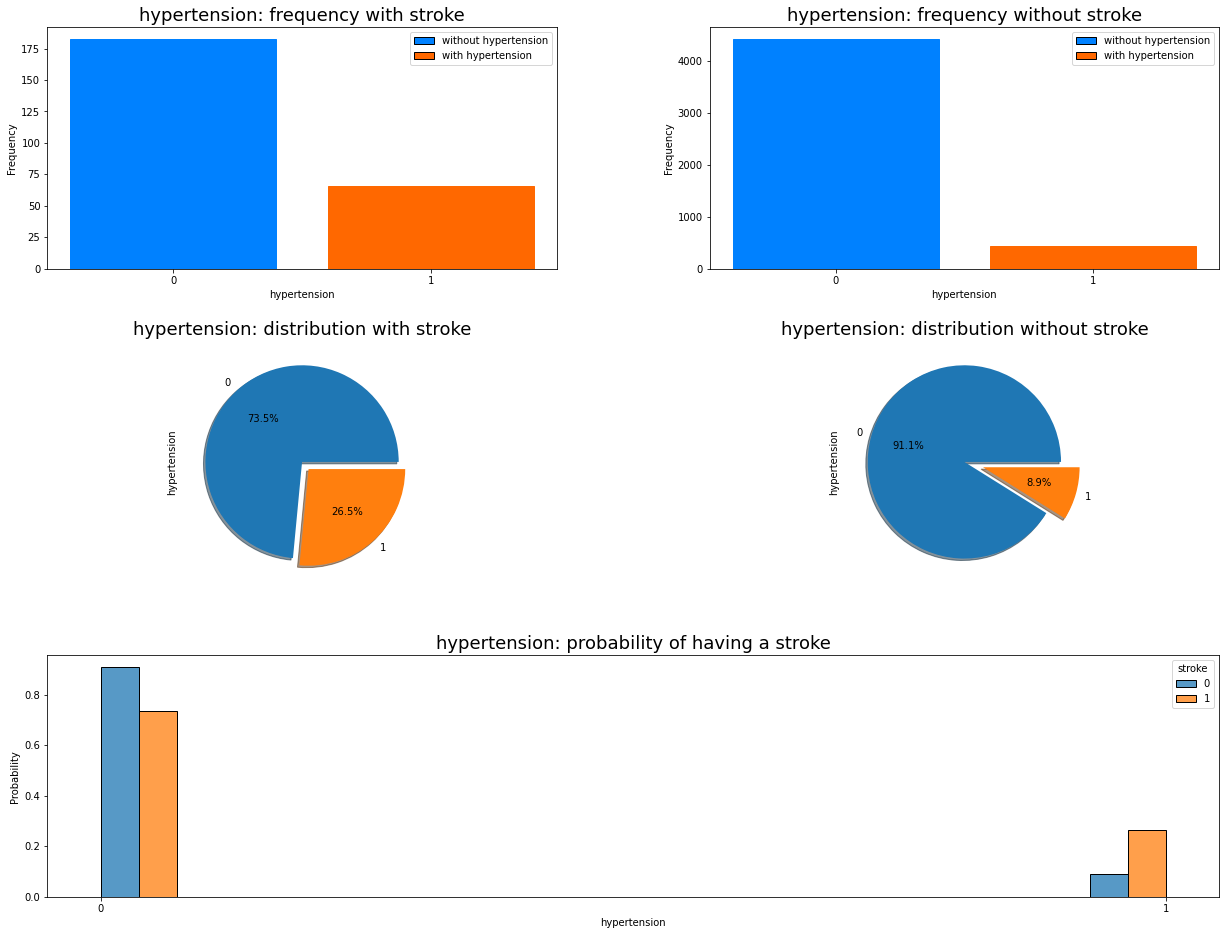

In [ ]:
hypertensionsWithStroke = df[df["stroke"]==1].groupby("hypertension")["hypertension"].count().reset_index(name='counts')
hypertensionsWithoutStroke = df[df["stroke"]==0].groupby("hypertension")["hypertension"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot hypertension frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(hypertensionsWithStroke["hypertension"].values, hypertensionsWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("hypertension")
plt.xticks(np.arange(0, 2, 1))
plt.title("hypertension: frequency with stroke", size=18)
labels= ["without hypertension","with hypertension"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot hypertension frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(hypertensionsWithoutStroke["hypertension"].values, hypertensionsWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("hypertension")
plt.xticks(np.arange(0, 2, 1))
plt.title("hypertension: frequency without stroke", size=18)
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot hypertension distribution with stroke
plt.subplot(grid[1, 0])
plt.title("hypertension: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('hypertension')['hypertension'].count().plot(kind='pie', y='hypertension', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot hypertension distribution without stroke
plt.subplot(grid[1, 1])
plt.title("hypertension: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('hypertension')['hypertension'].count().plot(kind='pie', y='hypertension', autopct='%1.1f%%', shadow = True, explode=(0, 0.2))

# plot hypertension probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="hypertension", hue="stroke",  stat="probability", common_norm=False, multiple="dodge")
plt.xticks([0,1])
plt.title('hypertension: probability of having a stroke', size=18)

plt.show()

### **Heart disease and stroke**

> **Risultato**: chi è affetto da cardiopatia è più predisposto ad avere un ictus

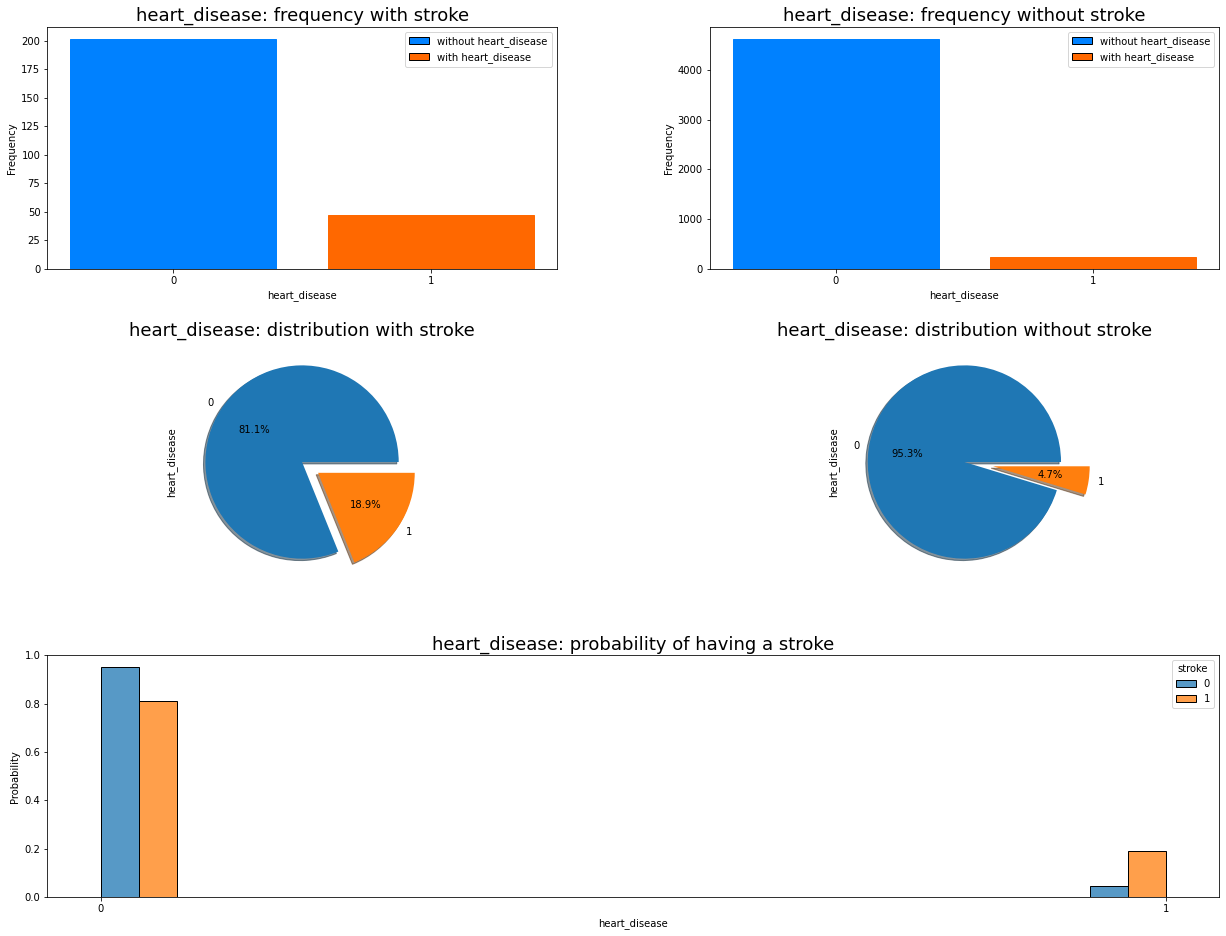

In [ ]:
heartDiseaseWithStroke = df[df["stroke"]==1].groupby("heart_disease")["heart_disease"].count().reset_index(name='counts')
heartDiseaseWithoutStroke = df[df["stroke"]==0].groupby("heart_disease")["heart_disease"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot heart_disease frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(heartDiseaseWithStroke["heart_disease"].values, heartDiseaseWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("heart_disease")
plt.xticks(np.arange(0, 2, 1))
plt.title("heart_disease: frequency with stroke", size=18)
labels= ["without heart_disease", "with heart_disease"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot heart_disease frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(heartDiseaseWithoutStroke["heart_disease"].values, heartDiseaseWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("heart_disease")
plt.xticks(np.arange(0, 2, 1))
plt.title("heart_disease: frequency without stroke", size=18)
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot heart_disease distribution with stroke
plt.subplot(grid[1, 0])
plt.title("heart_disease: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('heart_disease')['heart_disease'].count().plot(kind='pie', y='heart_disease', autopct='%1.1f%%', shadow = True, explode=(0, 0.2))

# plot heart_disease distribution without stroke
plt.subplot(grid[1, 1])
plt.title("heart_disease: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('heart_disease')['heart_disease'].count().plot(kind='pie', y='heart_disease', autopct='%1.1f%%', shadow = True, explode=(0, 0.3))

# plot heart_disease probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="heart_disease", hue="stroke",  stat="probability", common_norm=False, multiple="dodge")
plt.xticks([0,1])
plt.title('heart_disease: probability of having a stroke', size=18)

plt.show()

### **Ever married and stroke**


> **Risultato**: chi è sposato, divorziato o vedovo è più predisposto ad avere un ictus

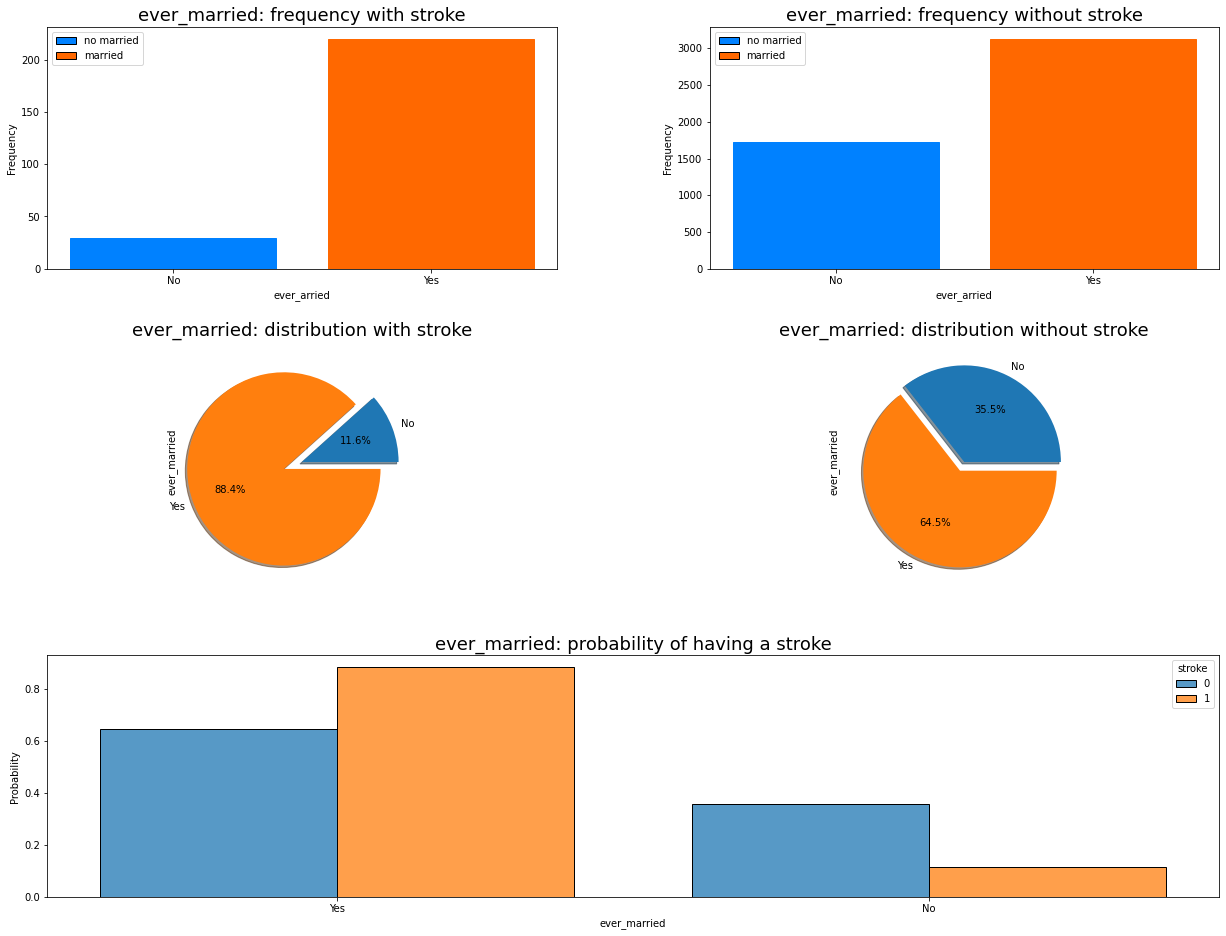

In [ ]:
marriedWithStroke = df[df["stroke"]==1].groupby("ever_married")["ever_married"].count().reset_index(name='counts')
marriedWithoutStroke = df[df["stroke"]==0].groupby("ever_married")["ever_married"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot ever_married frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(marriedWithStroke["ever_married"].values, marriedWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("ever_arried")
plt.title("ever_married: frequency with stroke", size=18)
labels= ["no married","married"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot ever_married frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(marriedWithoutStroke["ever_married"].values, marriedWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("ever_arried")
plt.title("ever_married: frequency without stroke", size=18)
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot ever_married distribution with stroke
plt.subplot(grid[1, 0])
plt.title("ever_married: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('ever_married')['ever_married'].count().plot(kind='pie', y='ever_married', autopct='%1.1f%%', shadow = True, explode=(0, 0.2))

# plot ever_married distribution without stroke
plt.subplot(grid[1, 1])
plt.title("ever_married: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('ever_married')['ever_married'].count().plot(kind='pie', y='ever_married', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot ever_married probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="ever_married", hue="stroke",  stat="probability", common_norm=False, multiple="dodge", shrink=.8)
plt.title('ever_married: probability of having a stroke', size=18)

plt.show()

## **Work type**

> Risultato: chi lavora è più predisposto ad avere un ictus, soprattutto se è un lavoratore autonomo

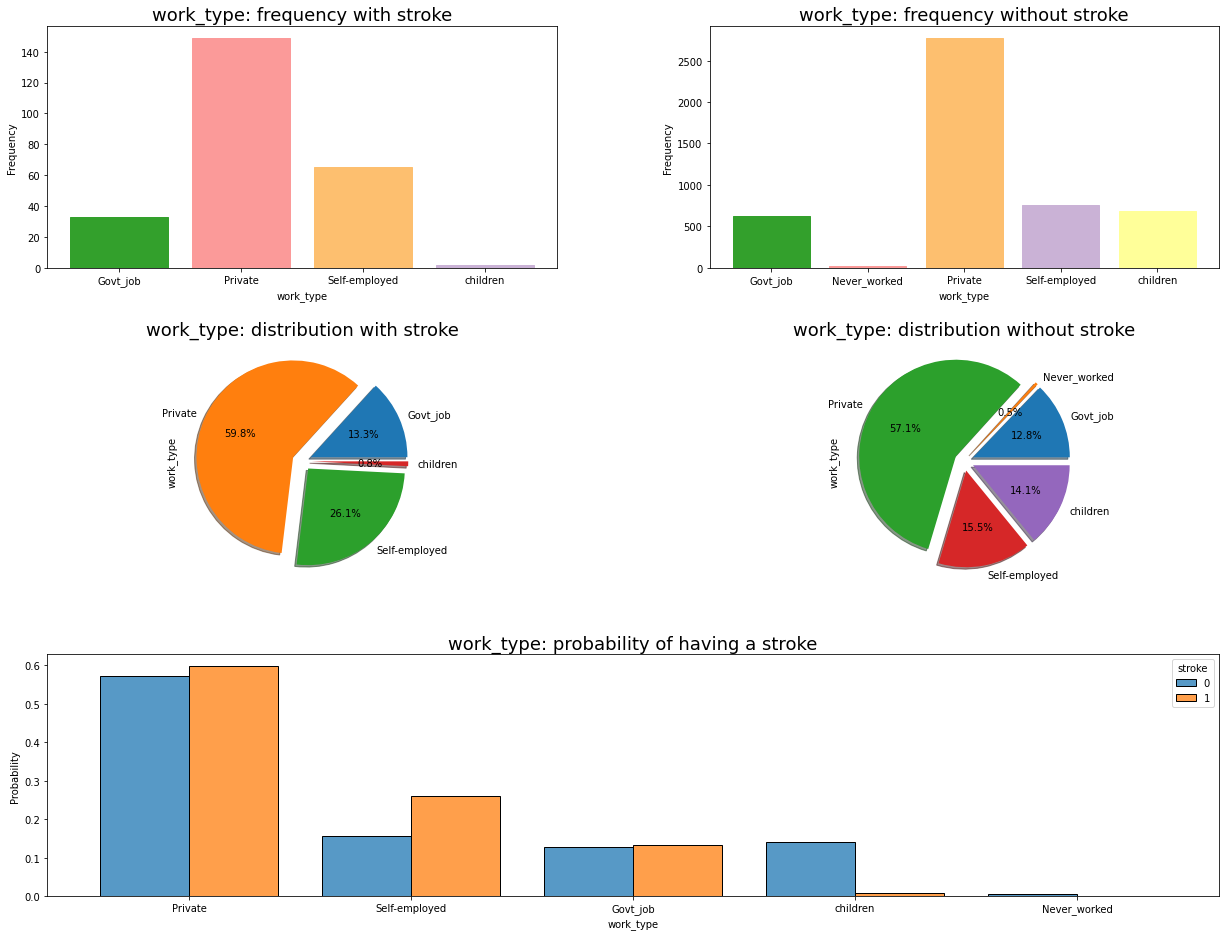

In [ ]:
work_typeWithStroke = df[df["stroke"]==1].groupby("work_type")["work_type"].count().reset_index(name='counts')
work_typeWithoutStroke = df[df["stroke"]==0].groupby("work_type")["work_type"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot work_type frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(work_typeWithStroke["work_type"].values, work_typeWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("work_type")
plt.title("work_type: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot work_type frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(work_typeWithoutStroke["work_type"].values, work_typeWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("work_type")
plt.title("work_type: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot work_type distribution with stroke
plt.subplot(grid[1, 0])
plt.title("work_type: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('work_type')['work_type'].count().plot(kind='pie', y='work_type', autopct='%1.1f%%', shadow = True, explode=(0.1, 0.1, 0.1, 0.1))

# plot work_type distribution without stroke
plt.subplot(grid[1, 1])
plt.title("work_type: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('work_type')['work_type'].count().plot(kind='pie', y='work_type', autopct='%1.1f%%', shadow = True, explode=(0.1, 0.1, 0.1, 0.1, 0.1))

# plot work_type probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="work_type", hue="stroke",  stat="probability", common_norm=False, multiple="dodge",  shrink=.8)
plt.title('work_type: probability of having a stroke', size=18)
plt.show()

### **Residence type and stroke**

> **Risultato**: chi lavora in città è più predisposto ad avere un ictus

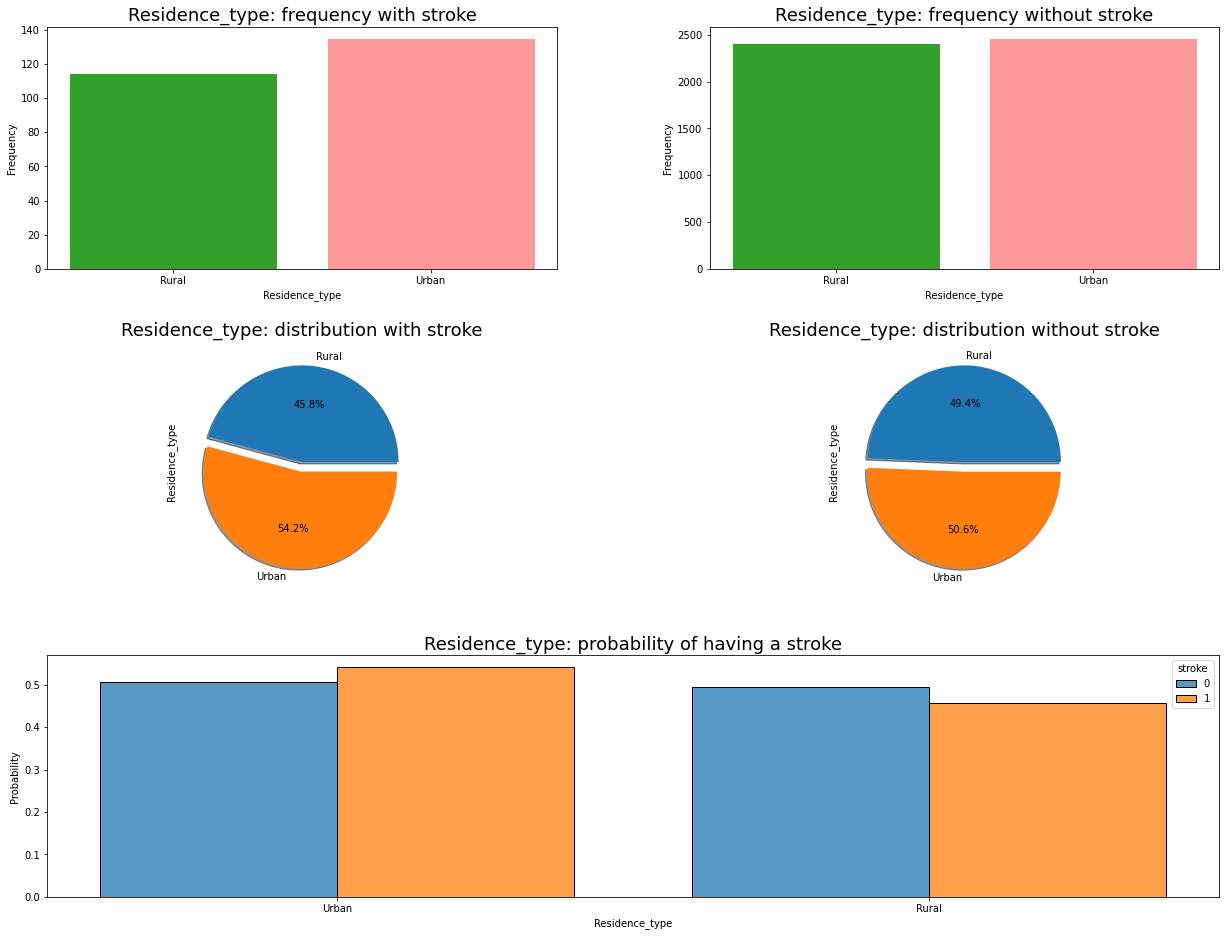

In [ ]:
residenceTypeWithStroke = df[df["stroke"]==1].groupby("Residence_type")["Residence_type"].count().reset_index(name='counts')
residenceTypeWithoutStroke = df[df["stroke"]==0].groupby("Residence_type")["Residence_type"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot Residence_type frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(residenceTypeWithStroke["Residence_type"].values, residenceTypeWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("Residence_type")
plt.title("Residence_type: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot Residence_type frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(residenceTypeWithoutStroke["Residence_type"].values, residenceTypeWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("Residence_type")
plt.title("Residence_type: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot Residence_type distribution with stroke
plt.subplot(grid[1, 0])
plt.title("Residence_type: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('Residence_type')['Residence_type'].count().plot(kind='pie', y='Residence_type', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot Residence_type distribution without stroke
plt.subplot(grid[1, 1])
plt.title("Residence_type: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('Residence_type')['Residence_type'].count().plot(kind='pie', y='Residence_type', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot Residence_type probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="Residence_type", hue="stroke",  stat="probability", common_norm=False, multiple="dodge", shrink=.8)
plt.title('Residence_type: probability of having a stroke', size=18)
plt.show()

## **Smoking status and strokes**

> **Risultato**: chi in passato fumava o attualmente fuma è più predisposto ad avere un ictus. Inoltre chi in passato fumava è più a rischio di chi attualmente fuma.

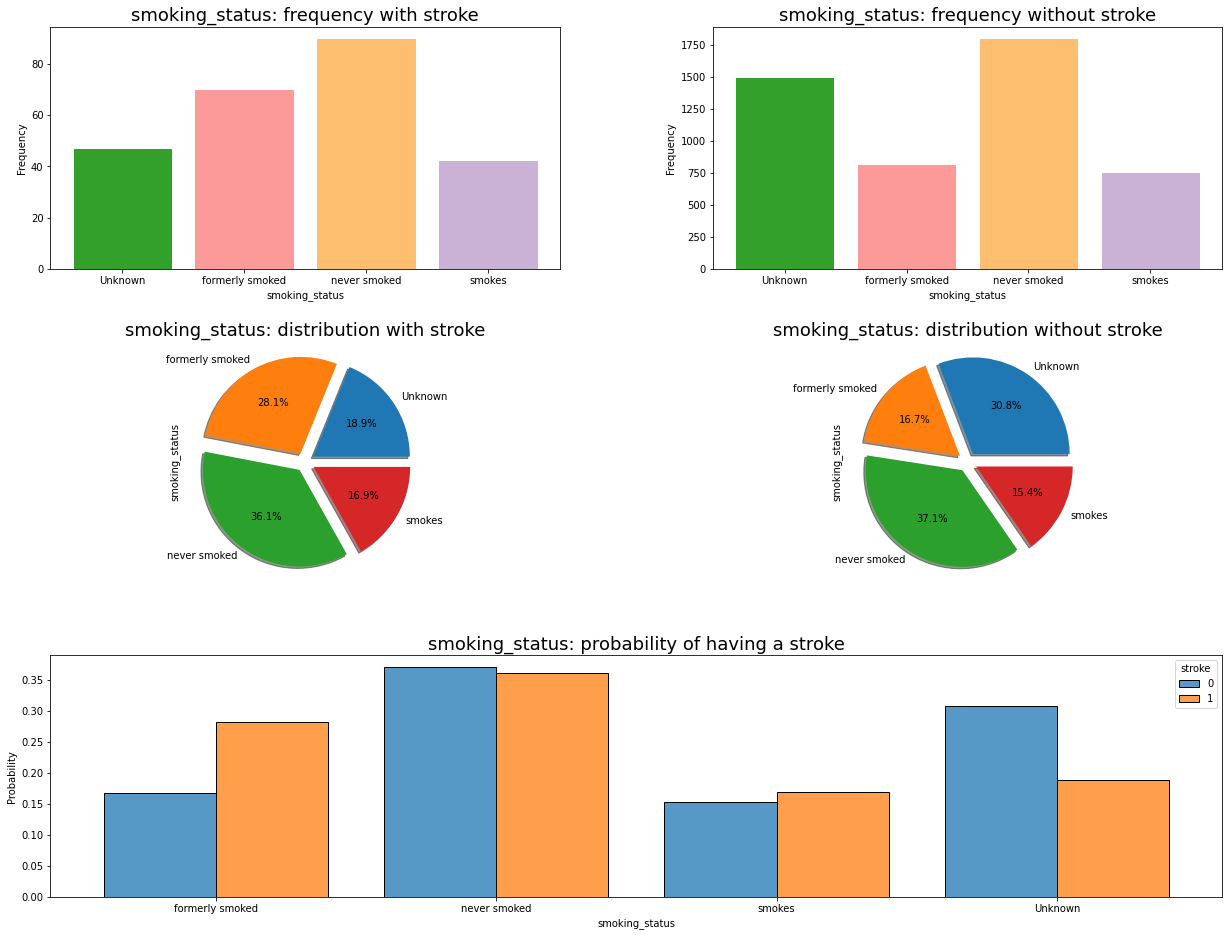

In [ ]:
smokeWithStroke = df[df["stroke"]==1].groupby("smoking_status")["smoking_status"].count().reset_index(name='counts')
smokeWithoutStroke = df[df["stroke"]==0].groupby("smoking_status")["smoking_status"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot smoking_status frequency with stroke
plt.subplot(grid[0, 0])
plot= plt.bar(smokeWithStroke["smoking_status"].values, smokeWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("smoking_status")
plt.title("smoking_status: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot smoking_status frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(smokeWithoutStroke["smoking_status"].values, smokeWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("smoking_status")
plt.title("smoking_status: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot smoking_status distribution with stroke
plt.subplot(grid[1, 0])
plt.title("smoking_status: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('smoking_status')['smoking_status'].count().plot(kind='pie', y='smoking_status', autopct='%1.1f%%', shadow = True,explode=(0.1, 0.1, 0.1, 0.1))

# plot smoking_status distribution without stroke
plt.subplot(grid[1, 1])
plt.title("smoking_status: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('smoking_status')['smoking_status'].count().plot(kind='pie', y='smoking_status', autopct='%1.1f%%', shadow = True,explode=(0.1, 0.1, 0.1, 0.1))

# plot smoking_status probability of having a stroke
plt.subplot(grid[2,0:]) # get space of all columns
sns.histplot(df, x="smoking_status", hue="stroke",  stat="probability", common_norm=False, multiple="dodge", shrink=.8)
plt.title("smoking_status: probability of having a stroke", size=18)
plt.show()

### **Age and stroke**

> **Risultato**: chi è più anziano è più predisposto ad avere un ictus

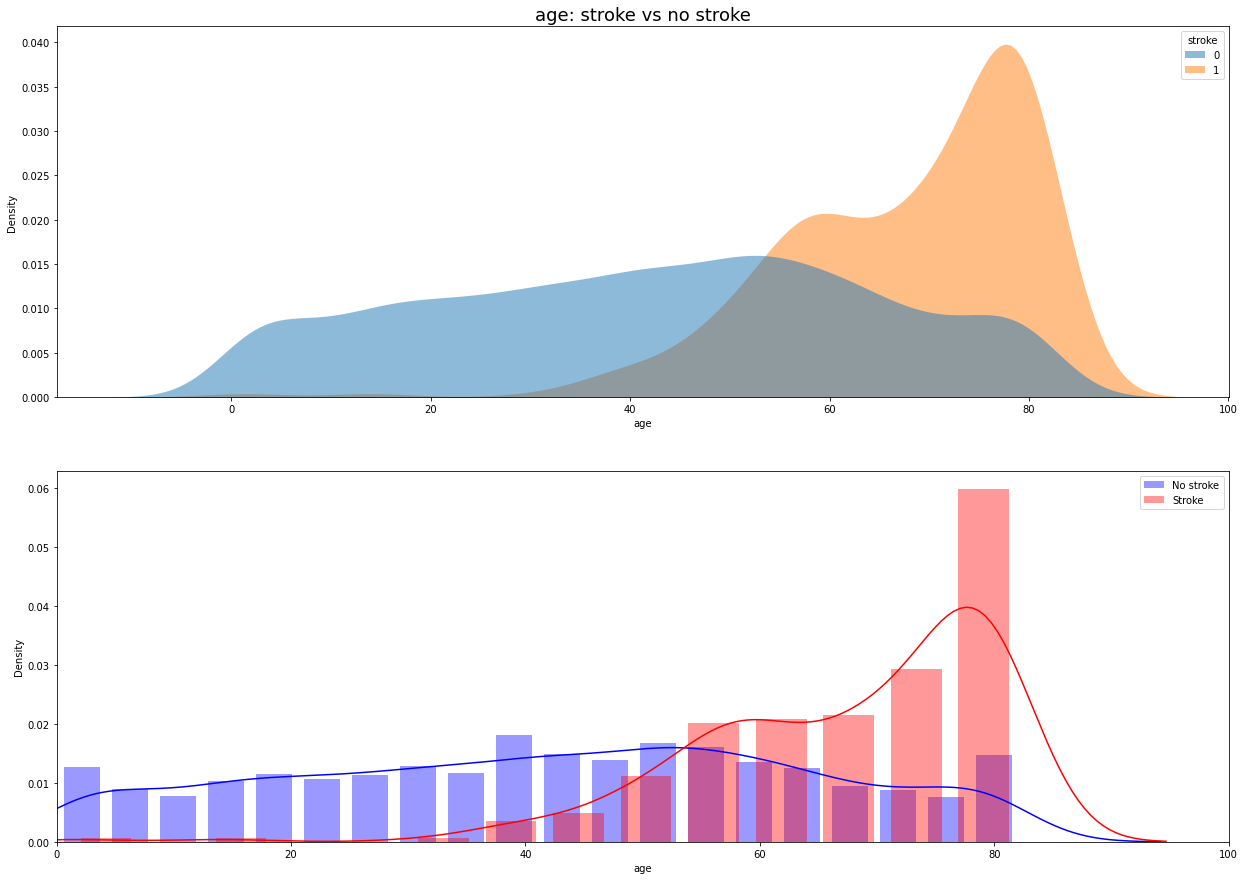

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(21,15)) # 2 rows and 1 column

# kernel density estimate (KDE) plot
sns.kdeplot(data=df, x='age', hue="stroke", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=axs[0]);
axs[0].set_title('age: stroke vs no stroke', size=18)

# distribution plot (this function combines the matplotlib hist function with the seaborn kdeplot())
sns.distplot(df[df['stroke'] == 0]["age"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75}, ax=axs[1])
sns.distplot(df[df['stroke'] == 1]["age"], label='Stroke', color='red', hist_kws={"rwidth":0.75}, ax=axs[1])

plt.xlim([0,100])
plt.legend()
plt.show()

### **Average glucose level and stroke**

> Risultato: più alto è il livello di glucosio e più si è predisposti ad un ictus

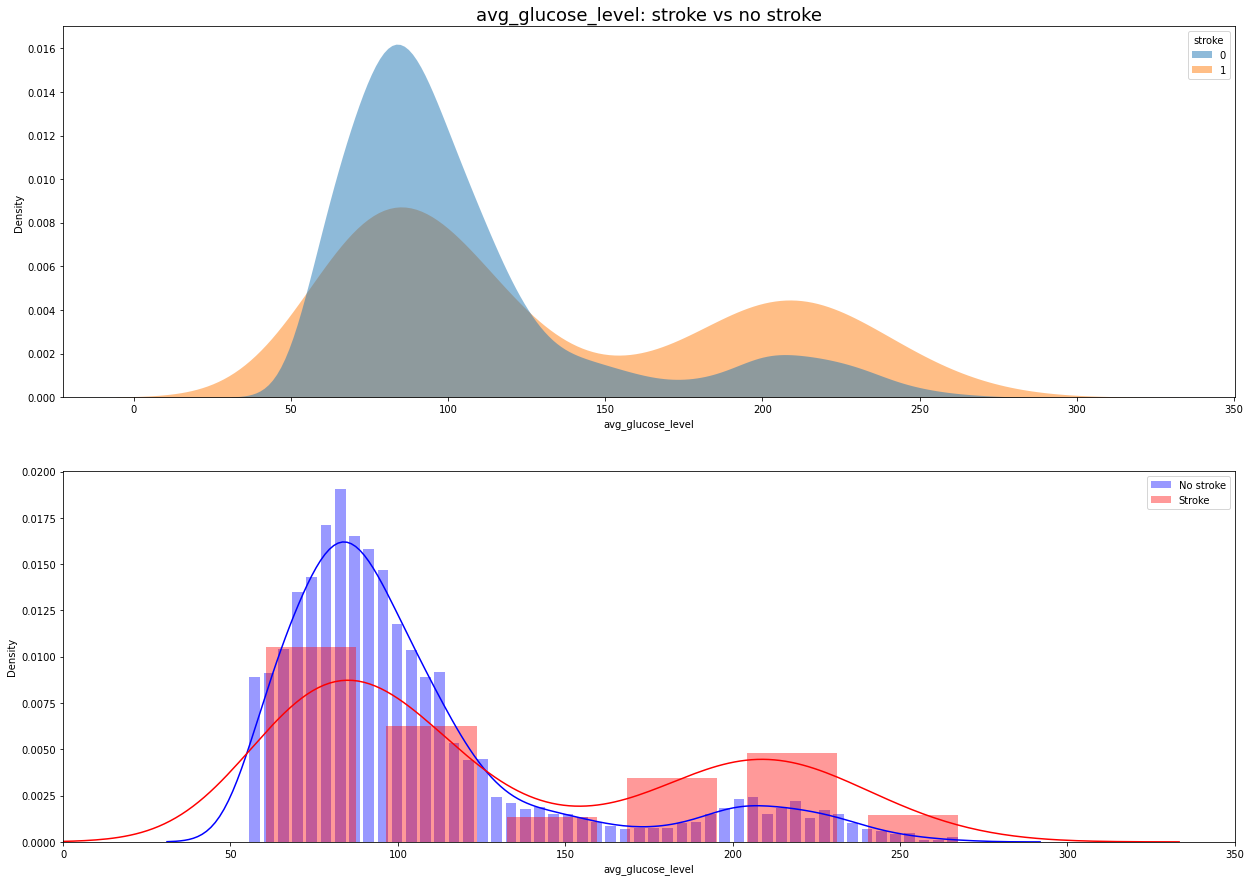

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(21,15)) # 2 rows and 1 column

# kernel density estimate (KDE) plot
sns.kdeplot(data=df, x='avg_glucose_level', hue="stroke", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=axs[0]);
axs[0].set_title('avg_glucose_level: stroke vs no stroke', size=18)

# distribution plot (this function combines the matplotlib hist function with the seaborn kdeplot())
sns.distplot(df[df['stroke'] == 0]["avg_glucose_level"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75}, ax=axs[1])
sns.distplot(df[df['stroke'] == 1]["avg_glucose_level"], label='Stroke', color='red', hist_kws={"rwidth":0.75}, ax=axs[1])

plt.xlim([0,350])
plt.legend()
plt.show()

### **BMI and strokes**

Le classi di peso per gli adulti indicate dal BMI sono:
* minori di 18.5 = sottopeso;
* 18.5 – 24.9 = normopeso;
* 25 – 29.9 = sovrappeso; 
* maggiori di 30 = obesità.

> Risultato: il bmi ci indica che chi è in sovrappeso rischia di più di avere un ictus, vediamo scendere la probabilità verso l'obesità probabilmente a causa della mancanza di dati.



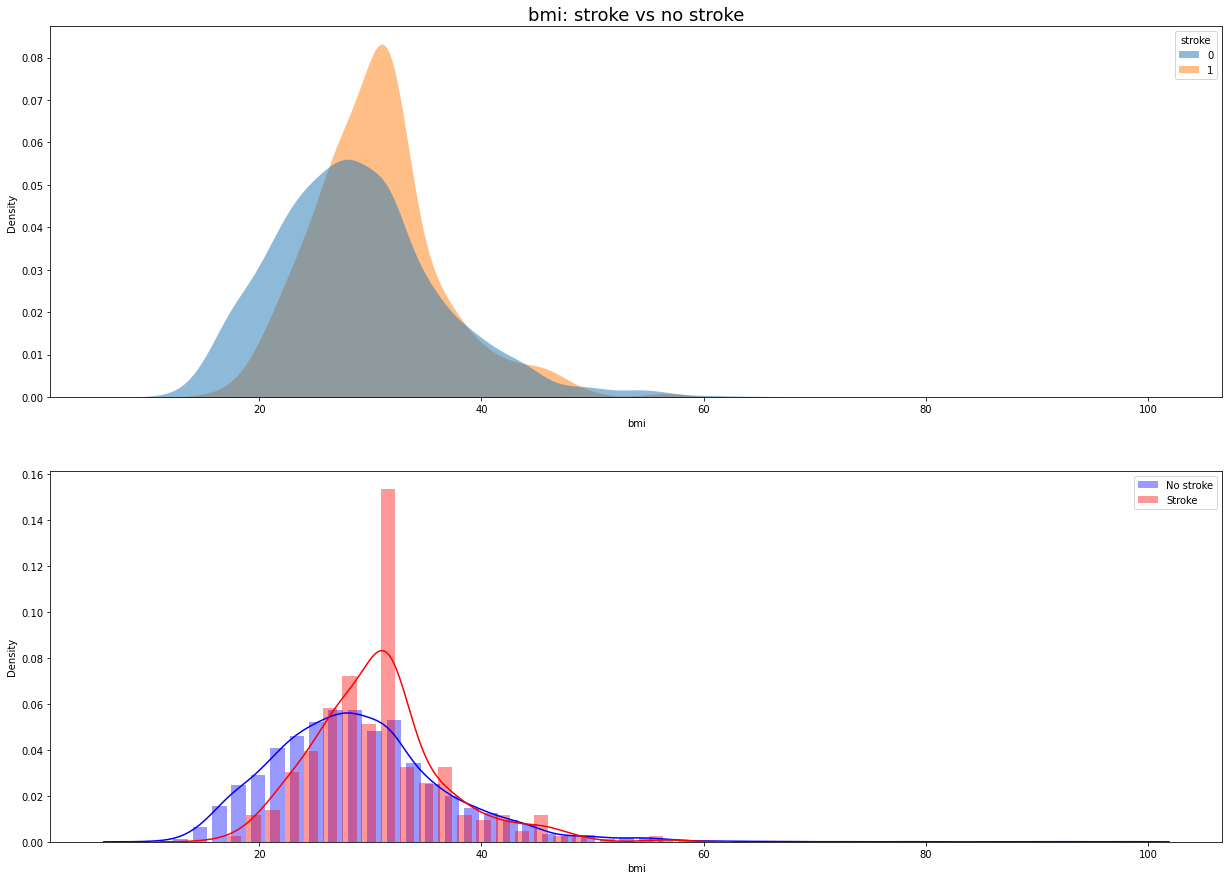

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(21,15))  # 2 rows and 1 column

# kernel density estimate (KDE) plot
sns.kdeplot(data=df, x='bmi', hue="stroke", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=axs[0]);
axs[0].set_title('bmi: stroke vs no stroke', size=18)

# distribution plot (this function combines the matplotlib hist function with the seaborn kdeplot())
sns.distplot(df[df['stroke'] == 0]["bmi"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75}, ax=axs[1])
sns.distplot(df[df['stroke'] == 1]["bmi"], label='Stroke', color='red', hist_kws={"rwidth":0.75}, ax=axs[1])

plt.legend()
plt.show()

Notiamo che dal valore 30 (inizio dell'obesità) in poi abbiamo 1900 persone senza ictus e solo 134 che hanno avuto un ictus.

In [ ]:
df[df['bmi']>30].groupby('stroke')['stroke'].count()

stroke
0    1900
1     134
Name: stroke, dtype: int64

Ingrandiamo su quel range di valori ovvero i valori >30 e notiamo che la maggior parte delle persone che hanno avuto un ictus sono raggruppate nel range [30 : 33] e poi probabilmente non avendo abbastanza dati la curva inizia a scendere.

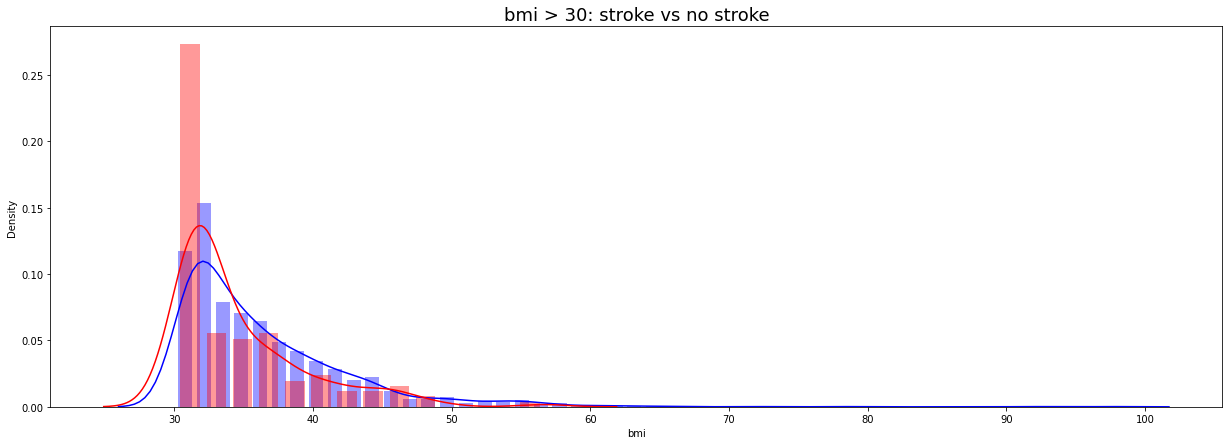

In [ ]:
plt.figure(figsize=(21,7))
plt.ylabel('Density', fontsize=10)
plt.title('bmi > 30: stroke vs no stroke', size=18)
sns.distplot(df[(df['stroke'] == 0) & (df['bmi']>30)]["bmi"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75})
sns.distplot(df[(df['stroke'] == 1)& (df['bmi']>30)]["bmi"], label='Stroke', color='red', hist_kws={"rwidth":0.75})
plt.show()

## **Feature Engineering**



*  **Applying Scaler method**





In [ ]:
_df = df.copy()
scaler = StandardScaler().fit(_df[numerical])
_df[numerical] = scaler.transform(_df[numerical])

_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,1.051242,0,1,Yes,Private,Urban,2.706450,0.990558,formerly smoked,1
1,51676,Female,0.785889,0,0,Yes,Self-employed,Rural,2.121652,0.356348,never smoked,1
2,31112,Male,1.626174,0,1,Yes,Private,Rural,-0.004867,0.459893,never smoked,1
3,60182,Female,0.255182,0,0,Yes,Private,Urban,1.437473,0.705811,smokes,1
4,1665,Female,1.581949,1,0,Yes,Self-employed,Rural,1.501297,-0.640267,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,1.626174,1,0,Yes,Private,Urban,-0.494481,0.356348,never smoked,0
5106,44873,Female,1.670400,0,0,Yes,Self-employed,Urban,0.420922,1.430622,never smoked,0
5107,19723,Female,-0.363976,0,0,Yes,Self-employed,Rural,-0.511266,0.213975,never smoked,0
5108,37544,Male,0.343633,0,0,Yes,Private,Rural,1.328375,-0.433178,formerly smoked,0


* **Applying One-hot encoding method**

In [ ]:
_df = _df.drop(columns=["id"])

_df = pd.get_dummies(data = _df, columns = np.setdiff1d(_df.columns.values,["age", "bmi", "avg_glucose_level", "heart_disease","hypertension","stroke"]))
_df = _df.reindex(sorted(_df.columns, key=lambda x: x.lower()), axis=1) # sort in alphabetic order

_df

,age,avg_glucose_level,bmi,ever_married_No,ever_married_Yes,gender_Female,gender_Male,heart_disease,hypertension,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown,stroke,work_type_children,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed
0,1.051242,2.706450,0.990558,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0
1,0.785889,2.121652,0.356348,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1
2,1.626174,-0.004867,0.459893,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,0.255182,1.437473,0.705811,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
4,1.581949,1.501297,-0.640267,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.626174,-0.494481,0.356348,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0
5106,1.670400,0.420922,1.430622,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
5107,-0.363976,-0.511266,0.213975,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
5108,0.343633,1.328375,-0.433178,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0


## **Features correlation**

> Risultato: nessuna feature influisce in modo particolare sull'avere un ictus. La correlazione più alta trovata è quella della feature 'age' con un valore di 0.2, che rimane comunque un valore molto basso.

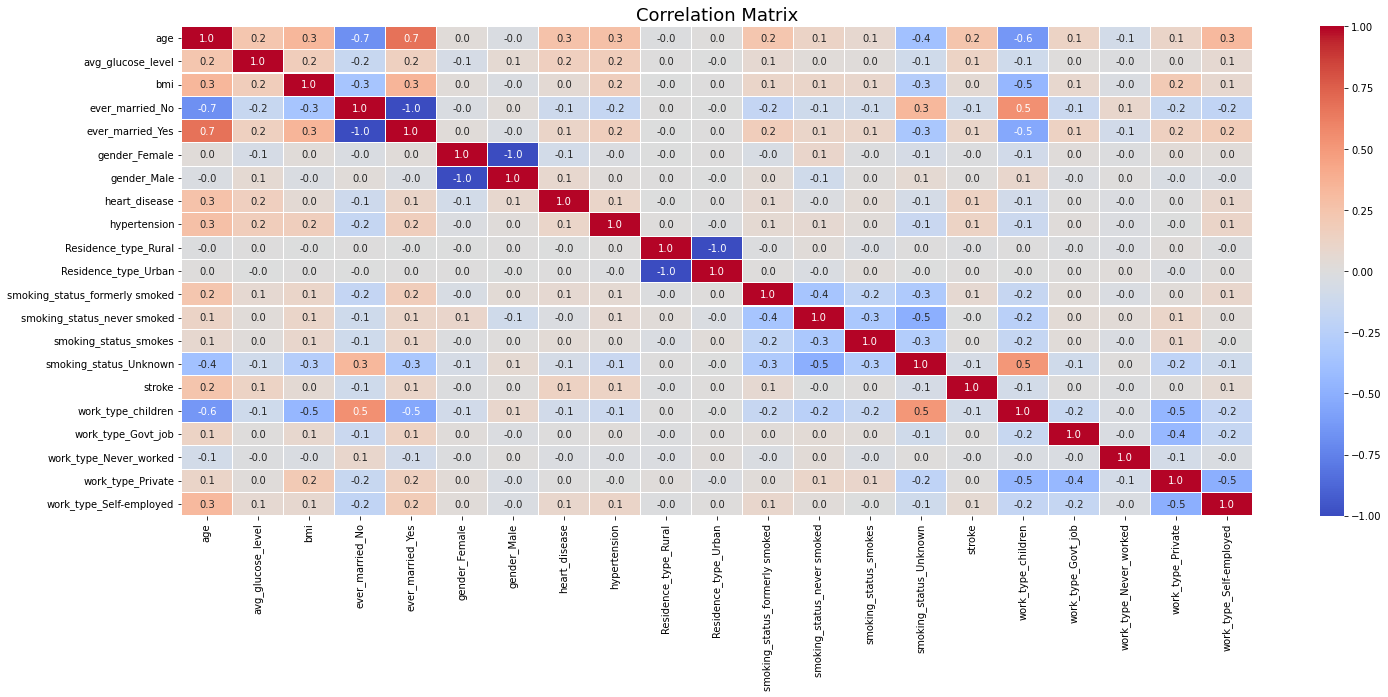

In [ ]:
plt.figure(figsize = (24, 9))
sns.heatmap(_df.corr(), cmap = "coolwarm", annot=True, fmt='.1f', linewidths=0.1);
plt.title('Correlation Matrix', size=18)
plt.show()

## **Train-Test Split Phase**

In [ ]:
X = _df.drop('stroke', axis=1).values
y = _df['stroke'].values

# split the full data 80:20 into training and testing sets respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, shuffle=True)

print('Train set size:', len(X_train),'\nTest set size:', len(X_test))

Train set size: 4087 
Test set size: 1022


## **k-Fold Cross Validation**

In [ ]:
kfold = KFold(n_splits=10, random_state=2020, shuffle=True)

models = [('Logistic Regression', LogisticRegression(max_iter=1000)),
             ('SVC', SVC()),
             ('Random Forest', RandomForestClassifier()),
             ('XGB', XGBClassifier()),
             ('LGBM', LGBMClassifier()),
             ('KNeighbors', KNeighborsClassifier())]

In [ ]:
mean = []

for name, model in models:
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy", n_jobs=-1)
    mean.append(cv_result.mean())

df_cross_val = pd.DataFrame({'k-Fold Accuracy Mean':mean}, index= [name for name, model in models] )
df_cross_val.sort_values(by=['k-Fold Accuracy Mean'], inplace= True, ascending= False)
df_cross_val

,k-Fold Accuracy Mean
Logistic Regression,0.951067
SVC,0.950823
XGB,0.950089
Random Forest,0.949110
KNeighbors,0.947643
LGBM,0.946418


## **The winner is Logistic Regression:**

In [ ]:
df_cross_val.iloc[df_cross_val['k-Fold Accuracy Mean'].argmax()]

k-Fold Accuracy Mean    0.951067
Name: Logistic Regression, dtype: float64

## **Testing Phase** (95% accuracy)

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
print("Accuracy", lr.score(X_test, y_test)*100, "%")

Accuracy 95.30332681017613 %


## **Features Importance**

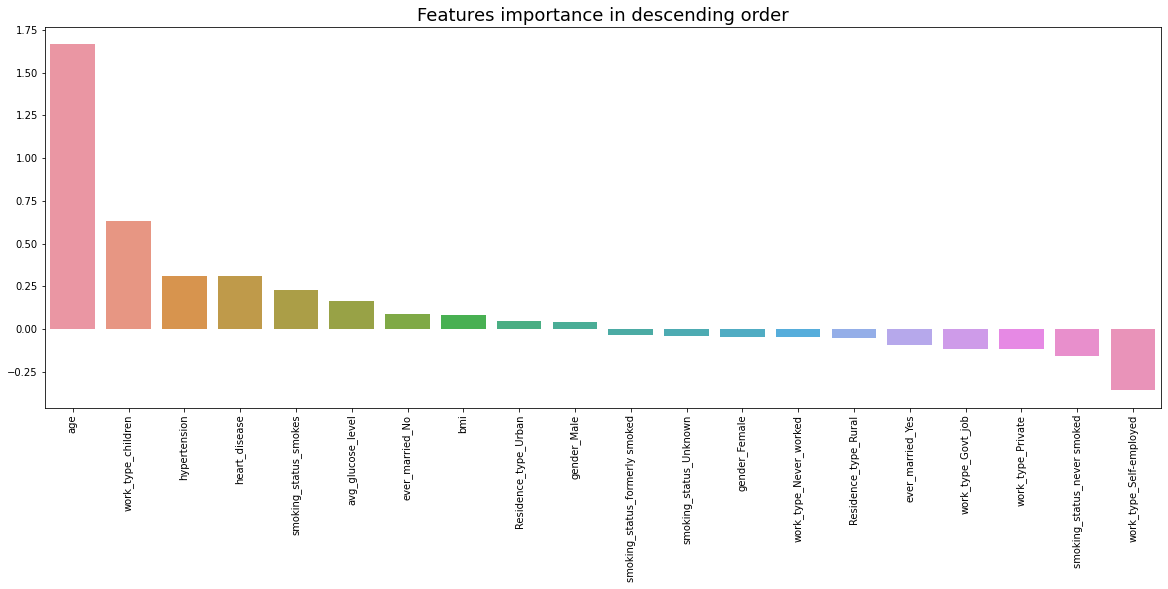

In [ ]:
importance = lr.coef_[0] # get importance values of the features for the model

features = list(zip(_df.drop('stroke', axis='columns').columns, importance)) # zip column names with their importance value
features.sort(key=lambda tup: tup[1], reverse=True) # order features by value in descending order

plt.figure(figsize=(20,7))
sns.barplot(x=[feature for feature, importance in features], y=[importance for feature, importance in features])
plt.xticks(rotation=90)
plt.title('Features importance in descending order', size=18)
plt.show()

## **Handle imbalanced data**

Abbiamo visto che i dati non erano bilanciati quindi abbiamo provato ad effettuare un oversampling per vedere se riusciamo ad ottenere un risultato migliore.

In [ ]:
_df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

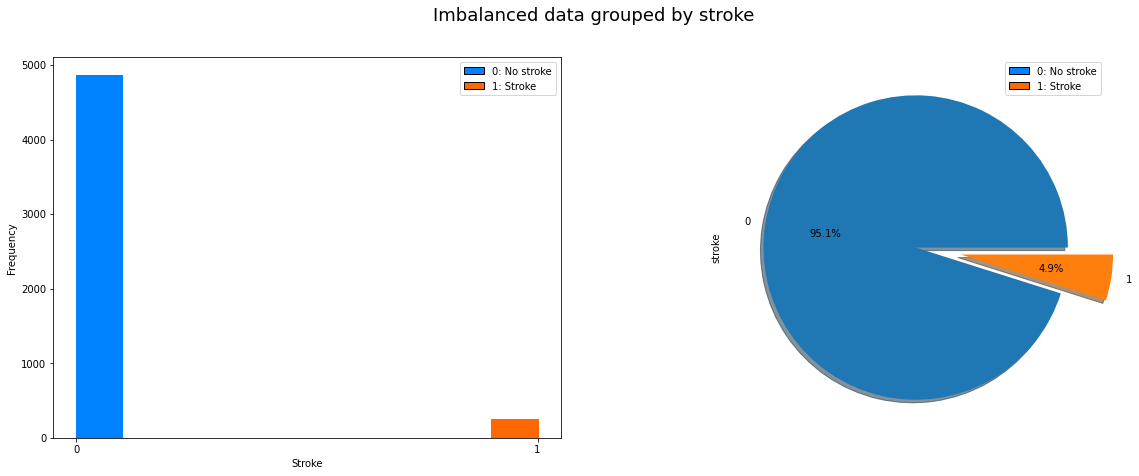

In [ ]:
plt.figure(figsize=(20,7))
plt.suptitle('Imbalanced data grouped by stroke', size=18)

# stroke frequency with hist plot
plt.subplot(1, 2, 1)
plt.xlabel('Stroke')
plt.xticks([0,1])
plot = _df['stroke'].plot.hist()
labels= ["0: No stroke","1: Stroke"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[len(plot.patches)-1].set_color(orange)

# stroke distribution with pie chart
plt.subplot(1, 2, 2)
_df.groupby('stroke')['stroke'].count().plot(kind='pie', y='stroke', autopct='%1.1f%%', shadow = True,  explode=(0, 0.3))
plt.legend(handles, labels)
plt.show()

## **Applying SMOTE OverSampling Method**



In [ ]:
X = _df.drop('stroke', axis='columns')
y = _df['stroke']

# applying smote method
smote = SMOTE(ratio='minority')
X_over,y_over = smote.fit_resample(X, y)

# rebuild dataframe
df_X_over = pd.DataFrame(X_over, columns=_df.drop('stroke', axis='columns').columns)
df_y_over = pd.DataFrame(y_over, columns=['stroke'])
df_over = pd.concat([df_X_over, df_y_over], axis=1)

df_over['stroke'].value_counts()

1    4860
0    4860
Name: stroke, dtype: int64

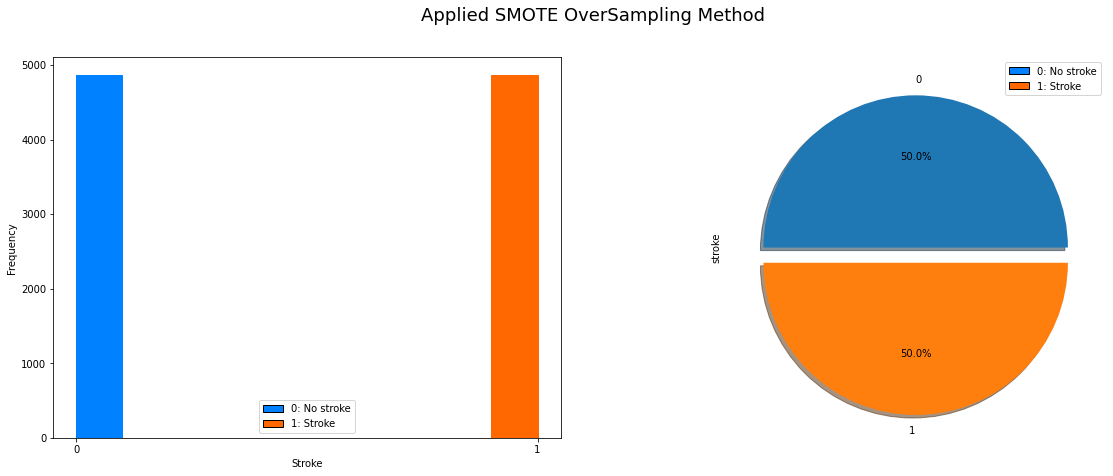

In [ ]:
plt.figure(figsize=(20,7))
plt.suptitle('Applied SMOTE OverSampling Method', size=18)

# stroke frequency with hist plot
plt.subplot(1, 2, 1)
plt.xlabel('Stroke')
plt.xticks([0,1])
plot = df_over['stroke'].plot.hist()
labels= ["0: No stroke","1: Stroke"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[len(plot.patches)-1].set_color(orange)

# stroke distribution with pie chart
plt.subplot(1, 2, 2)
df_over.groupby('stroke')['stroke'].count().plot(kind='pie', y='stroke', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))
plt.legend(handles, labels)
plt.show()

## **Train-Test Split Phase**

In [ ]:
# split the full data 80:20 into training and testing sets respectively
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=2020, shuffle=True)

print('Train set size:', len(X_train),'\nTest set size:', len(X_test))

Train set size: 7776 
Test set size: 1944


## **k-Fold Cross Validation**

In [ ]:
mean = []

for name, model in models:
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy", n_jobs=-1)
    mean.append(cv_result.mean())

df_cross_val = pd.DataFrame({'k-Fold Accuracy Mean':mean}, index= [name for name, model in models] )
df_cross_val.sort_values(by= ['k-Fold Accuracy Mean'], inplace= True, ascending= False)
df_cross_val

,k-Fold Accuracy Mean
Random Forest,0.964378
LGBM,0.956532
KNeighbors,0.904962
XGB,0.899821
SVC,0.865736
Logistic Regression,0.778807


## **The winner is Random Forest:**

In [ ]:
winner = df_cross_val.iloc[df_cross_val['k-Fold Accuracy Mean'].argmax()]
winner

k-Fold Accuracy Mean    0.964378
Name: Random Forest, dtype: float64

## **Testing Phase** (96% accuracy)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
print("Accuracy", rfc.score(X_test, y_test)*100, "%")

Accuracy 96.50205761316872 %


## **Features Importance**

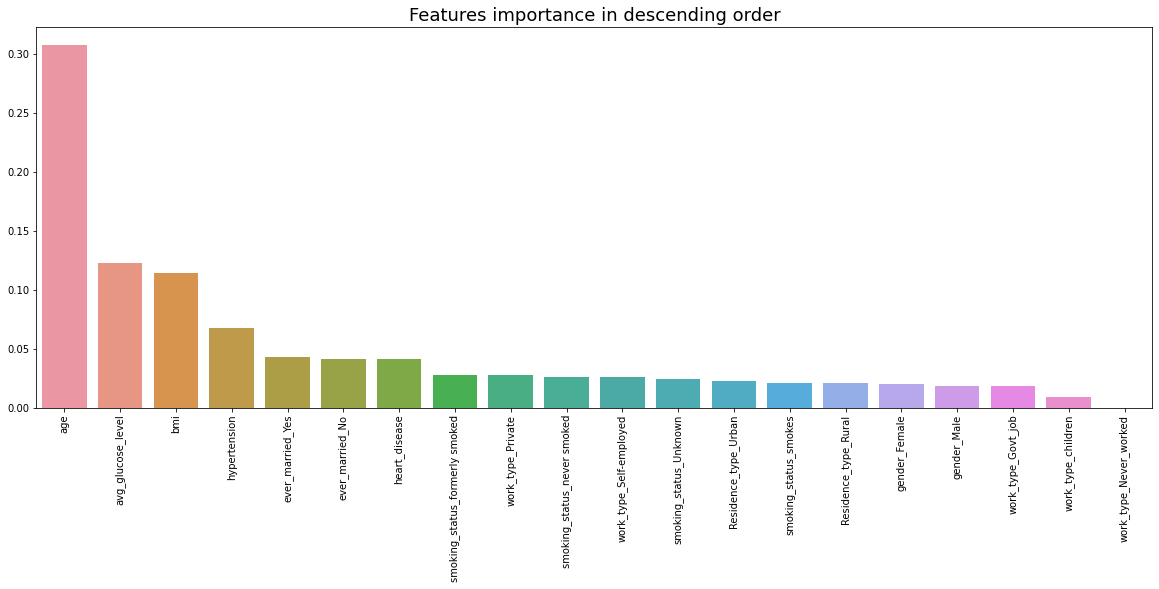

In [ ]:
importance = rfc.feature_importances_ # get importance values of the features for the model

features = list(zip(_df.drop('stroke', axis='columns').columns, importance)) # zip column names with their importance value
features.sort(key=lambda tup: tup[1], reverse=True) # order features by value in descending order

plt.figure(figsize=(20,7))
sns.barplot(x=[feature for feature, importance in features], y=[importance for feature, importance in features])
plt.xticks(rotation=90)
plt.title('Features importance in descending order', size=18)
plt.show()

## **Test if predict a stroke in our patient**

In [ ]:
data = {
 'age': 87,
 'avg_glucose_level': 150,
 'bmi': 32.5,
 'ever_married_No': 0,
 'ever_married_Yes': 1,
 'gender_Female': 0,
 'gender_Male': 1,
 'heart_disease': 1,
 'hypertension': 0,
 'Residence_type_Rural': 1,
 'Residence_type_Urban': 0,
 'smoking_status_formerly smoked': 0,
 'smoking_status_never smoked': 1,
 'smoking_status_smokes': 0,
 'smoking_status_Unknown': 0,
 'work_type_children': 0,
 'work_type_Govt_job': 0,
 'work_type_Never_worked': 0,
 'work_type_Private': 1,
 'work_type_Self-employed': 0}

predict_input = pd.DataFrame(data, index=[0])
predict_input[numerical] = scaler.transform(predict_input[numerical]) # applying standard scaler on numerical fields
predict_input

,age,avg_glucose_level,bmi,ever_married_No,ever_married_Yes,gender_Female,gender_Male,heart_disease,hypertension,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown,work_type_children,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed
0,1.935753,0.968619,0.459893,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0


In [ ]:
predict_result = rfc.predict(predict_input)[0]

if predict_result:
    print("Stroke predicted!")
else:
    print("No stroke risk.")

print("Stroke probability:", rfc.predict_proba(predict_input)[0][1], sep=' ')

Stroke predicted!
Stroke probability: 0.7
